# Are Individuals Profiting Off Of President Trump's Tweets in a Meaningful Way?

The motivation for this project was sparked by [Vanity Fair's article](https://www.vanityfair.com/news/2019/10/the-mystery-of-the-trump-chaos-trades), which made claims suggesting that someone has been making large S&P 500 futures trades based on President Trump's market-moving tweets, and, as a result, has been making massive profits. 

*“The precision and timing of these trades, and the vast amount of money being made as a result of them, make the traders wonder … are the people behind these trades incredibly lucky, or do they have access to information that other people don’t have about, say, Trump’s or Beijing’s latest thinking on the trade war or any other of a number of ways that Trump is able to move the markets through his tweeting or slips of the tongue?”*
<p style='text-align: right;'> <i>- Vanity Fair, October 16th, 2019</i> </p>

In order for an individual to be able to profit from Trump's tweets, they would need to know about the tweet before it is posted and whether this tweet will move the market up or down. Then, prior to the tweet, the individual would need to take on their position in the S&P 500 futures securities. If the tweet would move the market up, the individual would buy futures shares, and if the tweet would move the market down, the individual would short the futures shares. Either way, the size of the long or short positions would have to be very large. After the tweet is posted, the market moves, and the individual then either sells off their long position or buys futures shares to cover their short position. The difference between the sell price and the buy price multiplied by the number of shares, minus transaction costs, is what defines the profit that this individual makes. This would also imply that the individual is directly involved in insider trading.

Since the identities of all individuals making trades are protected, there is no way of identifying the matching buy and sell positions to see if anyone has made a profit based off of President Trump's tweets (unless the Securities and Exchange Commission decides to investigate this matter). Therefore, in order to be able to get an insight into this problem using data science, we will restate the question in a way that we can actually answer it: **Are Individuals Attempting to Profit off of President Trump's Tweets in a Meaningful Way?**

We will be analyzing the hourly volumes of S&P 500 futures in order to answer this question. We will first determine all abnormally high volumes. Then, we will see whether the spikes in volumes that preceded a market-moving tweet by President Trump are statistically significantly different from the spikes in volumes that did not precede a market-moving tweet by the President. In the end, we will try to find our own keywords that would classify a tweet by President Donald Trump as market-moving.

Things we'll cover:

0. [Importing Libraries](#0.-Importing-Libraries)
1. [Data Collection](#1.-Data-Collection)
2. [Overview of the S&P 500 Futures Volumes](#2.-Overview-of-the-S&P-500-Futures-Volumes)
3. [Relationship Between Volume Spikes and Trump's Tweets](#3.-Relationship-Between-Volume-Spikes-and-Trump's-Tweets)
4. [Finding Keywords in Trump's Tweets](#4.-Finding-Keywords-in-Trump's-Tweets)
5. [Concluding Remarks](#5.-Concluding-Remarks)

## 0. Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pylab import rcParams

import pandas as pd
import numpy as np

from scipy.stats import f_oneway
from scipy.stats import ttest_ind

import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

import re
import string
import nltk
nltk.download('words')
nltk.download('stopwords')
print("Done!")

Done!


[nltk_data] Downloading package words to /home/vagrant/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vagrant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%matplotlib inline
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 20,10
rcParams['font.size'] = 30
sns.set()

## 1. Data Collection
For this project we will be using President Donald Trump's tweets, daily volumes of the S&P 500 futures traded, and hourly volumes of the S&P 500 futures traded.

In order to collect President Trump's tweets, we initially tried to scrape data using the twitter API and the `twitter-python` library, but faced a limit of 3,200 most recent tweets for a given user. We then tried using the `twitterscraper` package, which allowed us to access far more tweets. However, with `twitterscraper`, we noticed that some of the output tweets were incomplete and the dataset contained duplicate tweets. Because of these data quality concerns, we resorted to downloading over 43,000 of the President's most recent tweets from an [online data source](http://www.trumptwitterarchive.com/).
The code that we wrote for the previous two methods of tweet collection, Twitter API and Twitterscraper, are provided in the 'Twitter API' and 'Twitterscraper' files.

In [3]:
# Load Trump twitter data
tweets = "trump_tweets.txt"
with open(tweets, "r", encoding = "ISO-8859-1") as file:
    data = json.loads(file.read())
df_all_tweets = pd.DataFrame(data)

# Format tweets and convert date to datetime type so we can filter based on dates
df_all_tweets["text"] = df_all_tweets["text"].str.lower()
df_all_tweets["created_at"]= pd.to_datetime(df_all_tweets["created_at"])

df_all_tweets = df_all_tweets.set_index("created_at")
df_all_tweets

,text,id_str
created_at,,
2019-12-03 17:45:10+00:00,rt @whitehouse: president @realdonaldtrump jus...,1201920324234813441
2019-12-03 16:26:48+00:00,rt @whitehouse: president @realdonaldtrump jus...,1201900602890104834
2019-12-03 16:26:14+00:00,rt @whitehouse: president trump has been fight...,1201900459688103936
2019-12-03 15:33:08+00:00,the united states of america supports the brav...,1201887098049089538
2019-12-03 12:43:23+00:00,rt @repmattgaetz: nancy pelosi and other house...,1201844376009428992
...,...,...
2009-05-12 14:07:28+00:00,"""my persona will never be that of a wallflower...",1773561338
2009-05-08 20:40:15+00:00,new blog post: celebrity apprentice finale and...,1741160716
2009-05-08 13:38:08+00:00,donald trump reads top ten financial tips on l...,1737479987


We downloaded the S&P 500 futures volumes, both daily and hourly, from the Bloomberg Terminal as Excel files. We then converted them to csv and uploaded them using the code below.

In [4]:
# Load the daily S&P 500 futures data from Nov. 2009 - Dec. 2019
df_daily = pd.read_csv('Daily.csv')

# Convert date to datetime type so we can filter based on dates
df_daily['Date'] = pd.to_datetime(df_daily['Date'])
df_daily

,Date,Last Price,Volume
0,2019-12-02,3114.75,1331642
1,2019-11-29,3143.75,902189
2,2019-11-27,3153.75,928792
3,2019-11-26,3143.75,1068011
4,2019-11-25,3132.75,947831
...,...,...,...
2522,2009-12-01,1108.50,1835688
2523,2009-11-30,1094.75,2016591
2524,2009-11-27,1089.50,1704981
2525,2009-11-25,1109.00,1078340


In [5]:
# Load the hourly intraday volumes
df_hourly = pd.read_csv("Intraday.csv").dropna()
df_hourly["Time Interval"] = pd.to_datetime(df_hourly["Time Interval"])

# Only keep the time interval and volume columns
df_hourly = df_hourly[["Time Interval", "Volume"]]
df_hourly

,Time Interval,Volume
0,2019-12-02 12:00:00,151396.0
1,2019-12-02 11:00:00,216579.0
2,2019-12-02 10:00:00,479666.0
3,2019-12-02 09:00:00,229054.0
4,2019-12-02 08:00:00,32560.0
...,...,...
5970,2018-11-25 22:00:00,8206.0
5971,2018-11-25 21:00:00,7477.0
5972,2018-11-25 20:00:00,9596.0
5973,2018-11-25 19:00:00,10696.0


## 2. Overview of the S&P 500 Futures Volumes
Before we try to answer the underlying question of this project, we will first explore how the S&P 500 futures trading volumes have changed from 2009 to 2019. We are especially interested in determining whether there are noticeably different fluctuations in the futures volumes traded before Trump's presidency as compared to during his presidency.

We only used the S&P 500 futures daily data starting in year 2009 as the market downturn in 2008 would skew our results. The dashed line on the plot below represents President Trump's inauguration date, January 20th, 2017.

Text(2017-03-20, 5932134.495, "Trump's Inauguration")

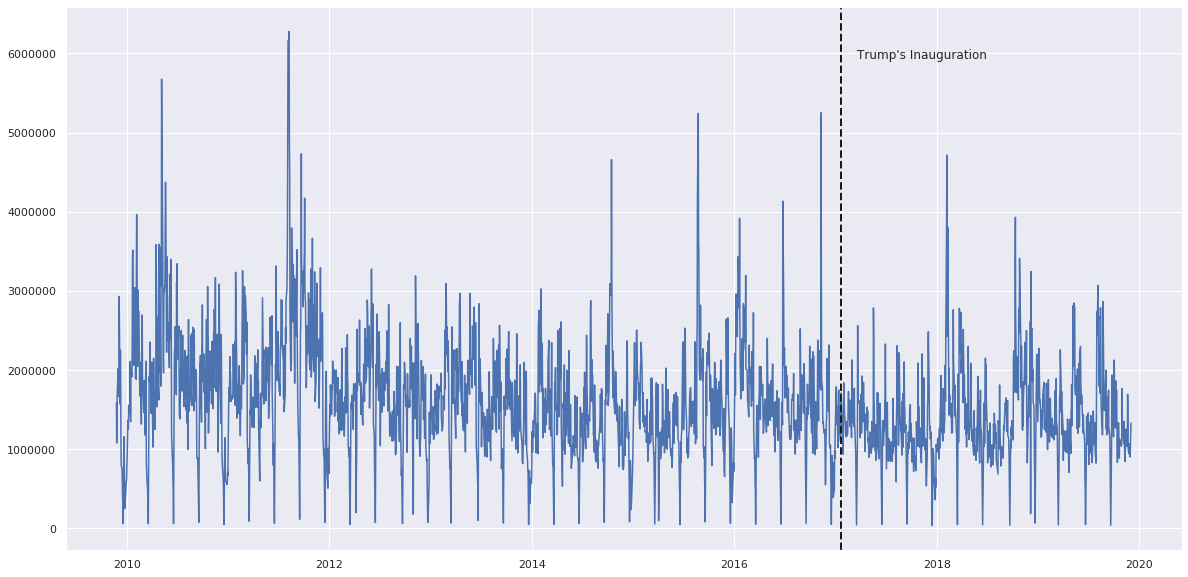

In [6]:
# Plot daily volumes
plt.figure()
plt.plot(df_daily['Date'], df_daily['Volume'])
plt.axvline('2017-01-20', color='k', linestyle="dashed", linewidth=2)
_, ymax = plt.ylim()
plt.text('2017-03-20' , ymax - ymax / 10,
        "Trump's Inauguration",)

From first glance, it seems like there were two large spikes in daily volumes traded in the years 2010 and 2012, followed by a relatively consistent trading volume period. However, starting in year 2015, there appears to be more volatility in the volumes. This is potentially interesting as the presidential elections were held in 2016.

We will run an independent t-test to see if the volumes traded before Trump's presidency differ from those traded during Trump's presidency.

First, we split the dataset into futures volumes traded before and after President Trump's inauguration day.

In [7]:
# Futures volumes before and after Trump's inauguration day (Jan 20, 2017)
df_before = df_daily[(df_daily['Date'] < '2017-01-20')]
df_after = df_daily[(df_daily['Date'] >= '2017-01-20')]

vol_before = np.array(df_before['Volume'])
vol_after = np.array(df_after['Volume'])

print('Size of vol_before dataset: ', vol_before.size)
print('Size of vol_after dataset: ', vol_after.size)

Size of vol_before dataset:  1804
Size of vol_after dataset:  723


Now, let's see the volume distributions of the two datasets.

Text(231892.69432918378, 1.209766848899061e-06, 'Mean after: 1391356')

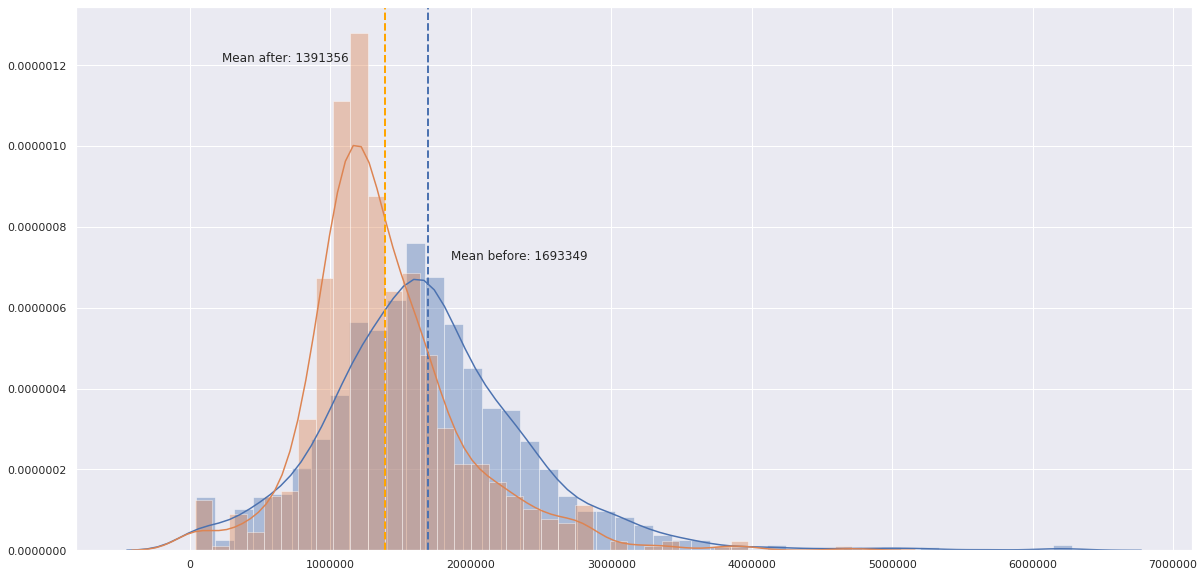

In [8]:
# Plot distribution before Trump's presidency
plt.figure()
ax1 = sns.distplot(vol_before)
plt.axvline(np.mean(vol_before), color='b', linestyle='dashed', linewidth=2)
_, ymax = plt.ylim()
plt.text(vol_before.mean() + vol_before.mean() / 10, ymax - ymax / 10,
        "Mean before: {:.0f}".format(vol_before.mean()),)

# Plot distribution after Trump's presidency
ax2 = sns.distplot(vol_after)
plt.axvline(np.mean(vol_after), color='orange', linestyle='dashed', linewidth=2)
_, ymax = plt.ylim()
plt.text(vol_after.mean() - vol_after.mean() / 1.2 , ymax - ymax / 10,
        "Mean after: {:.0f}".format(vol_after.mean()),)

Interestingly, the mean daily volume of S&P 500 futures trades is lower during the years of Trump's presidency than in the years before the presidency. Let's finally run the independent t-test to determine if this difference in the two distributions is statistically significant.

We will define a helper function, `run_ttest_ind`, that will provide us with the result of the independent t-test, given two datasets and an alpha at which we would reject the $H_o$ hypothesis.

In [9]:
def run_ttest_ind(A, B, alpha, ho, ha):
    stat, p = ttest_ind(A, B)
    print('Statistics=%.4f, p=%.4f' % (stat, p))
    if p > alpha:
        print('Fail to reject H0: ' + ho)
    else:
        print('Reject H0: ' + ha)

In this case we define our $H_o$ and $H_a$ as follows:

$H_o$: Volumes traded before and during Trump's presidency are the same

$H_a$: Volumes traded before and during Trump's presidency are different

In [10]:
run_ttest_ind(vol_before, vol_after, 0.01, 'Volumes are the same', 'Volumes are different')

Statistics=9.9114, p=0.0000
Reject H0: Volumes are different


Somewhat surprisingly, the volumes have changed between the two time periods significantly. S&P 500 futures volumes have decreased to a statistically significant level since Trump's presidency.

## 3. Relationship Between Volume Spikes and Trump's Tweets
We will now explore the underlying question of this project: **Are Individuals Attempting to Profit off of President Trump's Tweets in a Meaningful Way?**

In order for the answer to this question to be yes, the individuals would need to either buy a significant amount of the futures shares or short them right before the President's tweet is sent.

Therefore, in order to answer the question, we will analyze S&P 500 futures volumes traded on an hourly basis for a time period between Nov. 2018 and Dec. 2019. We will begin by finding all abnormal volume spikes and datetimes during which they occurred. Then, we will see if these spikes happened right before a significant tweet was sent by President Donald Trump. We will define the president's tweet as significant if it contains at least one of the keywords from JP Morgan's set of keywords. We will also define 'right before' as 2 hours or less before the President tweeted.

The keywords that JP Morgan came up with are part of their Volfefe Index, which measures the impact of Trump's tweets on the markets. Unfortunately, not all of the words that JP Morgan uses are publicly available, but a subset of the more popular words can be found [here](https://markets.businessinsider.com/news/stocks/jpmorgan-volvefe-index-on-impact-of-trump-tweets-on-market-volatility-2019-9-1028508499).

Let's first get a sense of the tweet dataframe that we loaded earlier.

In [11]:
df_all_tweets

,text,id_str
created_at,,
2019-12-03 17:45:10+00:00,rt @whitehouse: president @realdonaldtrump jus...,1201920324234813441
2019-12-03 16:26:48+00:00,rt @whitehouse: president @realdonaldtrump jus...,1201900602890104834
2019-12-03 16:26:14+00:00,rt @whitehouse: president trump has been fight...,1201900459688103936
2019-12-03 15:33:08+00:00,the united states of america supports the brav...,1201887098049089538
2019-12-03 12:43:23+00:00,rt @repmattgaetz: nancy pelosi and other house...,1201844376009428992
...,...,...
2009-05-12 14:07:28+00:00,"""my persona will never be that of a wallflower...",1773561338
2009-05-08 20:40:15+00:00,new blog post: celebrity apprentice finale and...,1741160716
2009-05-08 13:38:08+00:00,donald trump reads top ten financial tips on l...,1737479987


Great! We have over 43 thousand tweets and their corresponding times that go all the way back to 2009.

What about the hourly volumes of S&P 500 futures? 

In [12]:
df_hourly

,Time Interval,Volume
0,2019-12-02 12:00:00,151396.0
1,2019-12-02 11:00:00,216579.0
2,2019-12-02 10:00:00,479666.0
3,2019-12-02 09:00:00,229054.0
4,2019-12-02 08:00:00,32560.0
...,...,...
5970,2018-11-25 22:00:00,8206.0
5971,2018-11-25 21:00:00,7477.0
5972,2018-11-25 20:00:00,9596.0
5973,2018-11-25 19:00:00,10696.0


Here we have nearly 6 thousand data points that begin on November 24, 2018. In order to avoid redundant computations, we'll reduce the twitter data to span the same time period as our hourly market data.

In [13]:
df_tweets = df_all_tweets.loc[:'2018-11-24']
df_tweets.index.size

7107

Now we'll find all significant tweets, which must contain at least one of the publically available JP Morgan's keywords.

In [14]:
# Find tweets that contain keywords
keywords = ["china", "billions", "products", "democrats", 
            "great", "dollars", "tariffs", "country", 
            "mueller", "border", "president", "congressman", 
            "people", "korea", "party", "years", 
            "farmers", "going", "trade", "never"]

df_signif_tweets = df_tweets[df_tweets["text"].str.contains('|'.join(keywords))]
df_signif_tweets.index.size

3975

This leaves us with nearly 4 thousand significant tweets spanning a little over a year.

Next, we will compute a set of abnormally high hourly futures volumes traded. We will consider the hourly volume to be abnormally high if it is at least one standard deviation above the mean hourly volume.

In [15]:
# Statistics of all intraday volumes
mean = df_hourly["Volume"].mean()
std = df_hourly["Volume"].std()

# Function that returns 1 if the volume is abnormally high
def abnormal_volume(row):
    if row["Volume"] > mean + std:
        return 1
    else:
        return 0
    
df_hourly["Abnormal"] = df_hourly.apply(lambda row: abnormal_volume(row), axis=1)

Let's see what percentage of the hourly volumes were abnormal.

In [16]:
df_hourly['Abnormal'].sum() / df_hourly['Abnormal'].count()

0.15514644351464435

Our goal is to find abnormal volumes that occurred at most two hours before Trump's significant tweet. Therefore, for each abnormal hourly volume amount, we will see if Trump tweeted within the next two hours. In other words, we will separate all individual hours with abnormal volumes into two sets - one set of abnormal hourly volumes that were followed by a significant tweet within the next two hours, and a second set containing abnormal volumes that were not soon followed by a significant tweet.

In [17]:
# Filter intraday data to only keep abnormal volumes
df_hourly_abn = df_hourly[df_hourly['Abnormal'] == 1]
df_hourly_abn

,Time Interval,Volume,Abnormal
0,2019-12-02 12:00:00,151396.0,1
1,2019-12-02 11:00:00,216579.0,1
2,2019-12-02 10:00:00,479666.0,1
3,2019-12-02 09:00:00,229054.0,1
20,2019-11-29 12:00:00,210040.0,1
...,...,...,...
5935,2018-11-27 10:00:00,247063.0,1
5936,2018-11-27 09:00:00,211883.0,1
5953,2018-11-26 15:00:00,197177.0,1
5958,2018-11-26 10:00:00,207901.0,1


In [18]:
# Function that returns 1 if there was a significant tweet at most 2 hours later
def Trump_tweeted(row):
    start_time = row['Time Interval'] + pd.DateOffset(hours=1) 
    end_time = start_time + pd.DateOffset(hours=2)
    tweet_interval = df_tweets[end_time:start_time]
    tweet_count = len(tweet_interval.index)
    if tweet_count > 0:
        return 1
    else: return 0
    
# Add a column that indicates whether there was a tweet witin the next two hours   
df_hourly_abn["Tweeted"] = df_hourly_abn.apply(lambda row: Trump_tweeted(row), axis=1)
df_hourly_abn

,Time Interval,Volume,Abnormal,Tweeted
0,2019-12-02 12:00:00,151396.0,1,1
1,2019-12-02 11:00:00,216579.0,1,1
2,2019-12-02 10:00:00,479666.0,1,1
3,2019-12-02 09:00:00,229054.0,1,1
20,2019-11-29 12:00:00,210040.0,1,1
...,...,...,...,...
5935,2018-11-27 10:00:00,247063.0,1,1
5936,2018-11-27 09:00:00,211883.0,1,0
5953,2018-11-26 15:00:00,197177.0,1,0
5958,2018-11-26 10:00:00,207901.0,1,1


Now let's see what proportion of abnormal volumes were followed by at least one keyword containing Trump tweet within the next two hour period.

In [19]:
prop_tweets = df_hourly_abn['Tweeted'].sum() / df_hourly_abn['Tweeted'].count()

print('Abnormal and followed by tweet: ', prop_tweets)
print('Abnormal and not followed by tweet: ', 1 - prop_tweets)

Abnormal and followed by tweet:  0.5965480043149946
Abnormal and not followed by tweet:  0.40345199568500545


The data indicates that nearly 60% of hourly volumes that were abnormal were followed by a significant tweet by President Trump. While this is no indicator of correlation, we see that tweets and spikes in volumes could, potentially, be related. 

Let's now visualize the distribution of both sets of abnormal volumes - one set that was followed by a tweet and the other set that was not followed by a tweet.

In [20]:
vol_tweets = df_hourly_abn[df_hourly_abn['Tweeted'] == 1]['Volume']
vol_no_tweets = df_hourly_abn[df_hourly_abn['Tweeted'] == 0]['Volume']

print('Size of vol_tweets dataset: ', vol_tweets.index.size)
print('Size of vol_no_tweets dataset: ', vol_no_tweets.index.size)

Size of vol_tweets dataset:  553
Size of vol_no_tweets dataset:  374


Text(130731.80213903743, 1.0400086412632543e-05, 'Mean no tweets: 217886')

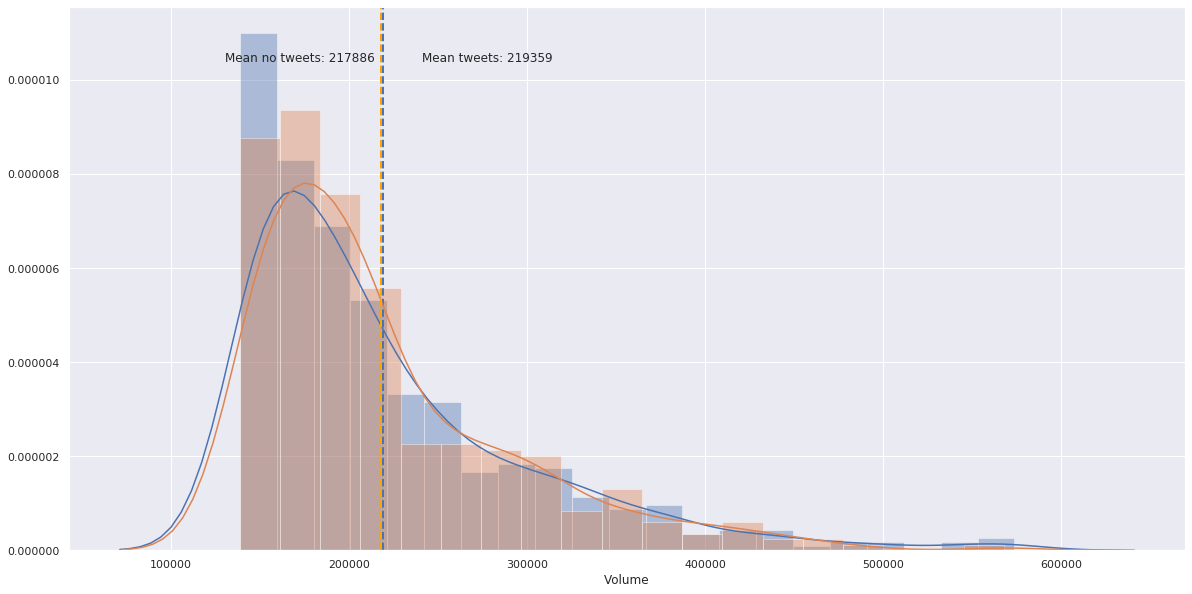

In [21]:
# BLUE
# Plot distribution of volumes followed by tweets
plt.figure()
ax1 = sns.distplot(vol_tweets)
plt.axvline(np.mean(vol_tweets), color='b', linestyle='dashed', linewidth=2)
_, xmax = plt.ylim()
plt.text(vol_tweets.mean() + vol_tweets.mean() / 10, xmax - xmax / 10,
        "Mean tweets: {:.0f}".format(vol_tweets.mean()),)

# ORANGE
# Plot distribution volumes that were not immediately followed by tweets
ax2 = sns.distplot(vol_no_tweets)
plt.axvline(np.mean(vol_no_tweets), color='orange', linestyle='dashed', linewidth=2)
_, xmax = plt.ylim()
plt.text(vol_no_tweets.mean() - vol_no_tweets.mean() / 2.5 , xmax - xmax / 10,
        "Mean no tweets: {:.0f}".format(vol_no_tweets.mean()),)

Although very similar, the two distributions above show that the mean of abnormal volumes followed by at least one significant tweet by President Trump within two hours have a slightly higher mean than the abnormal volumes that were not followed by a tweet.

Now we can perform the independent t-test to see whether the two sets of volumes are statistically different or not.

$H_o$: Volumes followed by a tweet and not followed by a tweet are the same

$H_a$: Volumes followed by a tweet and not followed by a tweet are the different

In [22]:
run_ttest_ind(vol_tweets, vol_no_tweets, 0.01, 'Volumes are the same', 'Volumes are different')

Statistics=0.2874, p=0.7738
Fail to reject H0: Volumes are the same


The result of our independent t-test shows that the difference of the two datasets was not statistically significant. In fact, we got a very high p-value of 0.77. We therefore conclude that there is insufficient evidence to claim that individuals have tried to profit off of President Donald Trump's tweets.

## 4. Finding Keywords in Trump's Tweets

While the t-test in the previous section showed that there is not enough evidence that the anticipation of President Trump's tweets (insider trading) is the main driver of abnormal trading volumes, we still believe that these tweets could have an impact on daily volumes traded. We will therefore try and find our own set of keywords similar to JP Morgan's that would classify Trump's tweets as market-moving. We define market-moving by the volumes traded, rather than the price value of the S&P 500. 

In this section, we will use daily volume data and conduct a logistic regression on it with Trump's tweets to see if there are certain keywords that lead to spikes in daily volumes. 

We begin by finding a set of means and standard deviations of daily volumes. When we first went about this, we decided to use one mean and one standard deviation over the period we were looking at. However, since the futures market is quite volatile, this gave us an enormous standard deviation that didn't allow us to pick up on abnormal trading days. We then tried calculating it year-by-year, but it still did not give us meaningful values. Therefore, we will calculate the mean and the standard deviation on a rolling basis, over each 15 day period, in order to pick up on the short term spikes and drops in volume.

We also decided to use the period dating back to the end of 2012 to have more data points. Between 2012 and the start of his presidential campaign in June 2015, Trump had hinted at running for president a few times, so we thought the tweets sent during that time period were relevant to include in our analysis.

In [23]:
df_daily_pres = df_daily[df_daily["Date"] > pd.Timestamp("2012-12-10")]
df_daily_pres = df_daily_pres.sort_values(by="Date")
df_daily_pres["Mean"] = df_daily_pres["Volume"].rolling(15).mean()
df_daily_pres["Std"] = df_daily_pres["Volume"].rolling(15).std()
df_daily_pres = df_daily_pres.dropna()

df_tweets_pres = df_all_tweets.loc[:"2012-12-10"]

print('Number of tweets: ', df_tweets_pres.index.size)
print('Number of days with volume measures: ', df_daily_pres.index.size)

Number of tweets:  38801
Number of days with volume measures:  1744


We will now compute all abnormal daily trading volumes during Trump's presidency. We will consider a volume abnormal if it is more than one 15-day rolling standard deviation away from the 15-day rolling mean. We will be considering both abnormally high and abnormally low volumes.

In [24]:
# Function that returns 1 if the volume is 1 std away
def abnormal_volume(row):
    mean = row["Mean"]
    std = row["Std"]
    if row["Volume"] > mean + std or row["Volume"] < mean - std:
        return 1
    else:
        return 0
    
df_daily_pres["Abnormal"] = df_daily_pres.apply(lambda row: abnormal_volume(row), axis=1)
df_daily_pres['Date'] = pd.to_datetime(df_daily_pres['Date'], utc=True)
print(df_daily_pres["Abnormal"].sum())

624


Let's see what proportion of days in this period were abnormal.

In [25]:
df_daily_pres['Abnormal'].sum() / df_daily_pres['Abnormal'].count()

0.3577981651376147

Just at a glance, there is a relatively large number of days where trading volumes were abnormal. We will now dive deeper into this and see if we can use what Trump tweeted that day to predict if a day will have an abnormal trading volume.

Since Trump tweets several times per day, instead of looking at a single tweet, we will look at all tweets from that day. We will group our tweets dataframe by day and concatenate all tweets within the group. We will then go through these concatenated tweets and preprocess them. The preprocess function removes any apostrophes, punctuation, links, and stopwords. We will also check to see if the lemmatized word is in fact an english word.

In [26]:
# Concat all tweets on same day
df_tweets_pres = df_tweets_pres.groupby(pd.Grouper(freq='D'))["text"].apply(lambda x: ' '.join(x)).reset_index()

stopwords = set(nltk.corpus.stopwords.words('english'))
words = set(nltk.corpus.words.words())

def preprocess(text, words, stopwords={}, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    text = text.lower()

    remove_s = text.replace("'s", "")
    remove_apostrophe = remove_s.replace("'", "")

    remove_apostrophe = re.sub("https?://t.co/[\\w]{10}", " ", remove_apostrophe)
    remove_punctuation = ''.join(l if l in string.ascii_letters or l in string.digits else " " for l in remove_apostrophe)
        
    l = nltk.word_tokenize(remove_punctuation)
    final = []
    for i in l:
        lem = lemmatizer.lemmatize(i)
        if lem not in stopwords and lem in words:
            final.append(lem)  
    return(" ".join(final))

df_tweets_pres["text"] = df_tweets_pres["text"].apply(lambda x: preprocess(x, words, stopwords))
df_tweets_pres = df_tweets_pres[df_tweets_pres["text"] != ""]
df_tweets_pres

,created_at,text
0,2012-12-11 00:00:00+00:00,good luck bob kraft coach bill tonight love wo...
1,2012-12-12 00:00:00+00:00,life life fragile success change anything succ...
2,2012-12-13 00:00:00+00:00,thanks sound great thanks true dopey never ban...
3,2012-12-14 00:00:00+00:00,windmill every country touch energy unreliable...
4,2012-12-15 00:00:00+00:00,horrible day country yesterday condolence fami...
...,...,...
2544,2019-11-29 00:00:00+00:00,thought wa business talk experience black voic...
2545,2019-11-30 00:00:00+00:00,small business create every net new job united...
2546,2019-12-01 00:00:00+00:00,sen say trump innocent way senate convict trum...
2547,2019-12-02 00:00:00+00:00,trump wa framed back correct maria never let h...


Great! Now that we have a preprocessed dataframe of tweets and a dataframe of daily volumes. Let's merge them together so that each daily volume corresponds to a prepocessed list of words of all of Trump's tweets from that day.

In [27]:
df_merged = pd.merge(left = df_daily_pres, right = df_tweets_pres, 
                  how = "inner", left_on = "Date", right_on = "created_at")
df_merged

,Date,Last Price,Volume,Mean,Std,Abnormal,created_at,text
0,2013-01-02 00:00:00+00:00,1457.00,1939320,1.072311e+06,636005.586733,1,2013-01-02 00:00:00+00:00,terrible deal country embarrassment republican...
1,2013-01-03 00:00:00+00:00,1453.50,1598235,1.060713e+06,623800.241630,0,2013-01-03 00:00:00+00:00,dont let get winner third party tough total me...
2,2013-01-04 00:00:00+00:00,1457.75,1509781,1.039380e+06,600664.101397,0,2013-01-04 00:00:00+00:00,thank true great nobody say love thanks jack h...
3,2013-01-07 00:00:00+00:00,1455.75,1189020,9.886242e+05,548050.097728,0,2013-01-07 00:00:00+00:00,thank work hard hi morgan good luck interview ...
4,2013-01-08 00:00:00+00:00,1452.25,1366989,1.010300e+06,556667.626742,0,2013-01-08 00:00:00+00:00,great true thanks true yes send address great ...
...,...,...,...,...,...,...,...,...
1728,2019-11-25 00:00:00+00:00,3132.75,947831,1.165979e+06,211034.893462,1,2019-11-25 00:00:00+00:00,unconventional bad thing heck fantastic read p...
1729,2019-11-26 00:00:00+00:00,3143.75,1068011,1.162232e+06,212324.420213,0,2019-11-26 00:00:00+00:00,president animal cruelty torture pact act law ...
1730,2019-11-27 00:00:00+00:00,3153.75,928792,1.152363e+06,219883.638126,1,2019-11-27 00:00:00+00:00,official aid country werent giving thank god b...
1731,2019-11-29 00:00:00+00:00,3143.75,902189,1.122287e+06,221280.976508,0,2019-11-29 00:00:00+00:00,thought wa business talk experience black voic...


Using this merged dataframe, we will now conduct a Logistic Regression to try and classify whether certain days will have abnormal volumes based on the specific words of Trump's tweets. We begin by finding the inverse document frequency of words.

In [28]:
tfidf = TfidfVectorizer(analyzer='word', max_features = 100)
train_matrix = tfidf.fit_transform(df_merged["text"])

We can now use this inverse document frequency sparse matrix to conduct the logistic regression. Here, we split the data into the training, validation, and test sets.

In [29]:
x, xtest, y, ytest = train_test_split(train_matrix.toarray(), df_merged["Abnormal"], test_size = 0.2)
xtrain, xcv, ytrain, ycv = train_test_split(x, y, test_size = 0.2)

We will now perform the logistic regression on the training set. One thing to note is we need to make sure that we balance the weights of the days with and without abnormal trading volumes to ensure that the days without abnormal volumes don't overpower the abnormal volume days. We will then fit the logistic regression on the training data and try to predict the validation and test data.

In [30]:
reg = LogisticRegression(C = 0.1, solver = "lbfgs", class_weight = "balanced")
reg.fit(xtrain, ytrain)
reg_pred_cv = reg.predict(xcv)
reg_pred_test = reg.predict(xtest)

Let's see how accurate our regression is. 

In [31]:
print("F1-score of cross validation for Logistic Regression: ", f1_score(ycv, reg_pred_cv))
print("F1-score of test for Logistic Regression: ", f1_score(ytest, reg_pred_test))

F1-score of cross validation for Logistic Regression:  0.40909090909090906
F1-score of test for Logistic Regression:  0.49826989619377154


After running the Logistic Regression a few times, we noticed that the F1-score for the cross validation set and test set hovered around 0.40. This value is around where we anticipated it to be since there are many other factors that influence the futures market. 

Had the F1-score been much higher, this could be an indication that Trump's tweets play a major role in moving futures markets, which is not true. Some of the other factors that play a role in volumes include Federal Reserve rate decisions, foreign developments such as Brexit or OPEC decisions, or simply economic indicators being released that point to the direction the US economy is heading. 

Trump's tweets alone don't account for all of the variation in the futures trading volumes. Nonetheless, it does appear that some of his tweets may have an impact on the market. The Logistic Regression did a decent job picking out days that had an abnormal volume and shows that Trump may have some influence on trading volumes.

Using the Logistic Regression, let's see what keywords made a significant impact on abnormal volume days.

In [32]:
features = sorted(zip(tfidf.get_feature_names(), reg.coef_[0]), key = lambda x : abs(x[1]), reverse = True)[:20]
features

[('back', 0.23924071966221785),
 ('better', 0.23768391217202225),
 ('going', 0.2267434493440858),
 ('run', 0.21908039332050958),
 ('bad', -0.20271604854556632),
 ('hard', -0.19971350471850885),
 ('forward', 0.19115803828175926),
 ('best', 0.18410299961336973),
 ('show', 0.18125204691676977),
 ('via', 0.17523994921161085),
 ('course', -0.17312566900425552),
 ('job', -0.15715738747421695),
 ('money', -0.15680132392943327),
 ('know', 0.153554426825454),
 ('many', -0.14989600358384642),
 ('much', 0.14671572631009816),
 ('ever', 0.14649116691994263),
 ('watch', -0.14611757314726687),
 ('like', -0.145872455586814),
 ('come', 0.14424091722966104)]

It's interesting to see some of the overlap between our keywords and JP Morgan's top 20 keywords. To get a better idea of how our Logistic Regression does compared to JP Morgan, let's run it 100 times and count the top 20 features for each run.

In [33]:
d = dict()
l = []
for i in range(100):
    tfidf = TfidfVectorizer(analyzer='word', max_features = 100)
    train_matrix = tfidf.fit_transform(df_merged["text"])
    
    x, xtest, y, ytest = train_test_split(train_matrix.toarray(), df_merged["Abnormal"], test_size = 0.2)
    xtrain, xcv, ytrain, ycv = train_test_split(x, y, test_size = 0.2)
    
    reg = LogisticRegression(C = 0.1, solver = "lbfgs", class_weight = "balanced")
    reg.fit(xtrain, ytrain)
    pred = reg.predict(xcv)
    pred1 = reg.predict(xtest)

    features = sorted(zip(tfidf.get_feature_names(), reg.coef_[0]), key = lambda x : abs(x[1]), reverse = True)[:20]
    for (i, j) in features:
        if i in d:
            d[i] += 1
        else:
            d[i] = 1
    
print("Done")

Done


Now let's visualize these keywords and see which ones come up as most frequent.

20% of the top 20 words found were keywords in JP Morgan's index


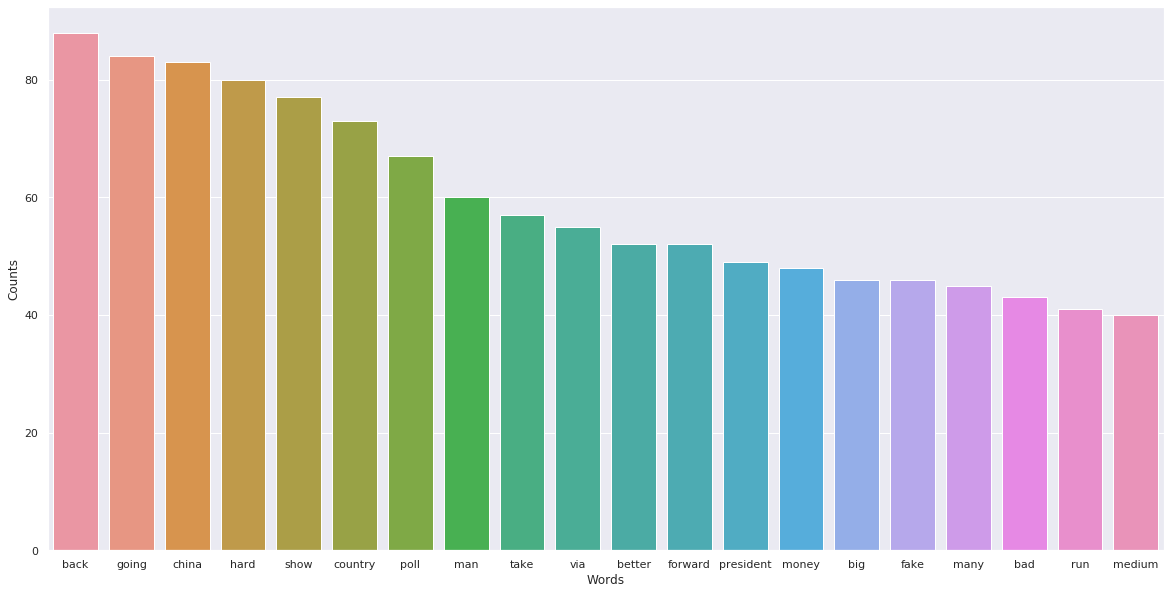

In [34]:
hist = sorted(list(d.items()), key = lambda x : x[1], reverse = True)[:20]
hist_df = pd.DataFrame(hist)
hist_df.columns = ["Words", "Counts"]

# Plot distribution of words
plt.figure()
ax1 = sns.barplot(x = "Words", y = "Counts", data = hist_df)

count_jp = 0
for i, j in hist:
    for k in keywords:
        if k.startswith(i):
            count_jp += 1

print(str(int(100 * count_jp/len(hist))) + "% of the top " + str(len(hist)) + " words found were keywords in JP Morgan's index")

## 5. Concluding Remarks
Our analysis of the question **Are Individuals Attempting to Profit off of President Trump's Tweets in a Meaningful Way?** resulted in a framework that could go beyond this project. 

We began our analysis with an overview of the S&P 500 futures market trading volumes throughout this past decade. Interestingly, we found that the volumes have significantly decreased. 

We then conducted a hypothesis test to see if there was evidence in the data of investors attempting to make significant profits off of Trump's tweets using the S&P 500 futures securities. We failed to reject our $H_o$, concluding that there is insufficient evidence that the abnormal trading volumes could be driven by an anticipation of a market-moving tweet by President Trump. Such a conclusion is not surprising as there are many factors that affect both futures prices and futures volumes traded. It would be very surprising if we were able to determine that Trump's tweets are the single main factor that drives the changes in volumes traded of this specific security, and we were very eager to see if there was such a possibility. The S&P 500 futures is also by no means the only security that could have been used to test our hypothesis. We chose it because it was the center of discussion in [Vanity Fair's article](https://www.vanityfair.com/news/2019/10/the-mystery-of-the-trump-chaos-trades). Some other interesting securities to take a look at are the [SPY](https://investorplace.com/2019/11/pay-attention-to-spy-etf/) or [IVV](https://www.nasdaq.com/articles/ishares-core-sp-500-etf-experiences-big-outflow-2019-11-15) ETFs (exchange-traded funds), both of which track the S&P 500 index.

We concluded our analysis by using a Logistic Regression to find a set of keywords in President Trump's tweets that are impacting futures volumes traded. This provided some insight into how some of the larger banks like JP Morgan are trying to pick up on different trends that impact the market, like keywords in tweets, to get an edge over their competitors. While we found keywords that have the most impact in predicting abnormal S&P 500 futures volumes traded, JP Morgan created the [Volfefe Index](https://www.bloomberg.com/news/articles/2019-09-09/jpmorgan-creates-volfefe-index-to-track-trump-tweet-impact) to track the impact of Trump's tweets on Treasury yields, and generated the most impactful keywords for that purpose. 

Overall, data analysis has significant importance in the financial markets. Any market insight derived from data analysis could give the company a significant edge over its competitors. [Here](https://www.bloomberg.com/professional/blog/3-ways-big-data-changing-financial-trading/) is an interesting reading on how banks are using big data in trading. [Here](https://data-flair.training/blogs/data-science-in-finance/) Data Flair discusses some of the most impactful ways data science is used in the finance field overall. Parts 6 and 7 - Fraud Detection and Algorithmic Trading - stand out in particular. In fact, fraud detection is often based on identifying abnormalities, which was one of the goals of our project, as well.


Thank you!